In [1]:
%%capture
!pip install wandb -qU

In [2]:
# Log in to your W&B account
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import os
from google.colab import drive

if not os.path.exists('/content/gdrive'):
  drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
config  = {
    'epochs': 5,
    'batch_size': 4,
    'num_filter' : [16, 32, 32],
    'weight_decay': 0.0005,
    'learning_rate': 1e-3,
    'seed': 42
    }

In [5]:
wandb.init(project='CNN_MRI', config=config)
wandb.run.name = '20241201' ## Run name
wandb.run.save()
config = wandb.config

wandb: Currently logged in as: dlsgml107 (dlsgml107-spidercore). Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


# 1. Preprocessing

### 데이터 불러오기

In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [7]:
df= pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/SMWU/2024/merge_prep.csv')
df

,PTID,BAT126,HMT10,HMT100,HMT102,HMT11,HMT12,HMT13,HMT15,HMT16,...,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl,AV45_bl
0,002_S_0295,194.0,0.52,31.0,33.0,0.17,0.03,182.0,66.6,23.2,...,NaN,NaN,NaN,NaN,NaN,888.1,355.2,34.73,NaN,NaN
1,002_S_0413,433.0,0.23,30.0,33.0,0.18,0.02,155.0,53.5,34.5,...,NaN,NaN,NaN,NaN,NaN,1006.0,107.3,10.57,NaN,NaN
2,002_S_0559,452.0,0.42,30.0,33.0,0.26,0.03,156.0,71.2,20.0,...,NaN,NaN,NaN,NaN,NaN,1245.0,188.6,15.82,NaN,NaN
3,002_S_0619,642.0,0.21,33.0,32.0,0.19,0.05,228.0,66.1,25.6,...,NaN,NaN,NaN,NaN,NaN,393.8,212.4,18.56,NaN,NaN
4,002_S_0685,322.0,0.39,30.0,33.0,0.19,0.08,357.0,62.8,27.4,...,NaN,NaN,NaN,NaN,NaN,1700.0,265.9,22.82,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,941_S_4376,525.0,0.21,31.0,32.0,0.12,0.09,209.0,54.8,35.3,...,1.00000,1.0,1.00000,1.0,1.00000,1700.0,277.0,23.97,1.303080,0.9419
1596,941_S_4377,256.0,0.59,30.0,34.0,0.11,0.04,262.0,51.6,37.2,...,2.00000,2.2,2.00000,2.5,2.15385,1349.0,312.6,26.47,1.392690,1.1362
1597,941_S_4420,747.0,0.50,31.0,33.0,0.07,0.02,180.0,60.9,26.4,...,1.00000,1.0,1.50000,NaN,1.41935,795.0,339.4,32.22,1.229150,1.3555
1598,941_S_4764,454.0,0.40,32.0,35.0,0.15,0.05,250.0,55.7,32.7,...,1.14286,1.4,1.20000,1.5,1.23684,912.4,295.5,27.57,1.340120,1.2638


압축해제 하지 않고 이미지 불러오기

In [8]:
import tarfile
import numpy as np
from PIL import Image
import io

In [9]:
tar_path = '/content/gdrive/MyDrive/Colab Notebooks/SMWU/2024/Image Dataset/ADNI_1Y_15T.tar'
tar = tarfile.open(tar_path, mode='r')

In [10]:
# tar.getnames()

In [11]:
# tar.getmembers()

In [12]:
images = []
labels = []
img_PTID = []
no_labels = []

# .tar 파일 열기
with tarfile.open(tar_path, "r") as tar:
    for member in tqdm(tar.getmembers()):

        # .jpg 파일만 처리
        if member.isfile() and member.name.lower().endswith('.jpg'):
            try:
                # tar 파일 내의 이미지 데이터를 읽어 메모리에 로드
                file_obj = tar.extractfile(member)
                if file_obj is not None:
                    PT_ID = member.name.split('/')[1]
                    if PT_ID in df['PTID'].values:
                        labels.append(df[df['PTID']==PT_ID]['DX_bl'].values[0])
                        image = Image.open(io.BytesIO(file_obj.read()))
                        images.append(image)
                        img_PTID.append(PT_ID)
                        # print(f"Loaded image: {member.name}")
                    else:
                        no_labels.append(PT_ID)


            except Exception as e:
                print(f"Failed to load image {member.name}: {e}")



100%|██████████| 13420/13420 [00:10<00:00, 1306.89it/s]


In [13]:
print(len(images))
print(len(labels))
print(len(no_labels))

12480
12480
300


In [14]:
set(no_labels)

{'012_S_0712',
 '013_S_1205',
 '023_S_0030',
 '023_S_0083',
 '027_S_0644',
 '027_S_1385',
 '027_S_1387',
 '041_S_1423',
 '067_S_0056',
 '098_S_0149',
 '098_S_0160',
 '123_S_0162',
 '137_S_0459',
 '137_S_0631',
 '141_S_0853'}

In [14]:
images[0].shape ### MRI Image는 192x192 사이즈에 채널이 3채널입니다.

### 문자형 레이블을 categorical number로 변환

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels_enc = le.fit_transform(labels)
labels_enc

array([2, 2, 2, ..., 2, 2, 2])

In [16]:
print(list(le.classes_))
print(le.transform(list(le.classes_)))

['AD', 'CN', 'LMCI']
[0 1 2]


In [17]:
from collections import Counter
Counter(labels_enc)

Counter({2: 6100, 1: 3860, 0: 2520})

### 이미지 전처리

In [18]:
img_size = []
for img in images:
    img_size.append(img.size)

result = Counter(img_size)
print(result)

Counter({(256, 256): 7660, (192, 192): 4820})


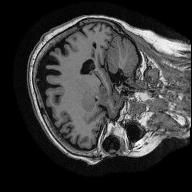

In [19]:
images[0]

In [20]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [21]:
img_tensors = []

transform = transforms.Compose([
        transforms.Resize((192,192)),  # 이미지 크기 조정
        transforms.ToTensor(),         # 텐서로 변환
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
    ])

for img in tqdm(images):
    img_tensor = transform(img)
    img_tensors.append(img_tensor)

100%|██████████| 12480/12480 [00:23<00:00, 524.74it/s]


In [22]:
print(len(img_tensors))
print(len(labels_enc))

12480
12480


# 2. Dataset Split

환자별로 20장의 데이터가 주어졌는데 이 20장의 이미지가 거의 비슷하기 때문에 환자를 무시하고 전부 랜덤으로 나누면 너무 쉬운 task가 됩니다. 그래서 1번 환자는 train, 2번 환자는 test... 처럼 환자를 기준으로 train-validation-test를 구분하겠습니다.

In [23]:
from sklearn.model_selection import train_test_split

train_val_ID, test_ID = train_test_split(list(set(img_PTID)), test_size=0.1, random_state=15)

train_ID, val_ID = train_test_split(train_val_ID, test_size=0.1, random_state=15)

print('# of train_set : %.0f, # of train_set : %.0f, # of test_set : %.0f' %(len(train_ID), len(val_ID), len(test_ID)))

# of train_set : 504, # of train_set : 57, # of test_set : 63


In [24]:
train_X = []
train_Y = []
val_X = []
val_Y = []
test_X = []
test_Y = []

for idx, id in enumerate(img_PTID):
    if id in train_ID:
        train_X.append(img_tensors[idx])
        train_Y.append(labels_enc[idx])
    elif id in val_ID:
        val_X.append(img_tensors[idx])
        val_Y.append(labels_enc[idx])
    elif id in test_ID:
        test_X.append(img_tensors[idx])
        test_Y.append(labels_enc[idx])
    else:
        print('{} error!!'.f(id))

In [25]:
tr_Y_valued = np.array(train_Y).reshape(-1,1)
val_Y_valued = np.array(val_Y).reshape(-1,1)
test_Y_valued = np.array(test_Y).reshape(-1,1)

tr_Y_valued

array([[2],
       [2],
       [2],
       ...,
       [2],
       [2],
       [2]])

In [26]:
print('# of train_set : %.0f, # of train_set : %.0f, # of test_set : %.0f' %(len(train_X), len(val_X), len(test_X)))

# of train_set : 10080, # of train_set : 1140, # of test_set : 1260


# 3. Model Training

In [27]:
import torch.nn as nn

In [28]:
import random

torch.manual_seed(config.seed)
random.seed(config.seed)
np.random.seed(config.seed)

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


### DataLoader

In [30]:
# Creating the dataset class
class CustomDataset(Dataset):
    # Constructor
    def __init__(self, x_, y_): ### (self는 무시하고) 데이터 보따리에 함수 순서 맞춰서 데이터 가져옴
        self.x_data = x_
        self.y_data = y_

    # getting data length
    def __len__(self): ### (self는 무시하고) 데이터 보따리 안에 있는 총 데이터 개수 카운트
        return len(self.x_data)

    # Getter
    def __getitem__(self, idx): ### (self는 무시하고) 데이터 보따리 안에 있는 데이터에 순서대로 index 붙여서 꺼내옴.
        # return torch.FloatTensor(self.x_data[idx]), torch.FloatTensor(self.y_data[idx])
        return torch.FloatTensor(self.x_data[idx]), torch.LongTensor(self.y_data[idx]) ### 위에꺼 에러나서 디버깅하다보니 되는걸로 변경

In [31]:
tr_dataset = CustomDataset(train_X, tr_Y_valued )
tr_dataloader = DataLoader(tr_dataset, batch_size=16, shuffle=True)

val_dataset = CustomDataset(val_X, val_Y_valued )
val_dataloader = DataLoader(val_dataset, batch_size=len(val_X), shuffle=False)

test_dataset = CustomDataset(test_X, test_Y_valued )
test_dataloader = DataLoader(test_dataset, batch_size=len(test_X), shuffle=False)

In [32]:
loader_iter = iter(tr_dataloader)
img = next(loader_iter)
img

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
           [0.0078, 0.0039, 0.0039,  ..., 0.0078, 0.0118, 0.0039],
           [0.0078, 0.0039, 0.0078,  ..., 0.0196, 0.0118, 0.0039],
           ...,
           [0.0000, 0.0078, 0.0078,  ..., 0.0431, 0.0157, 0.0000],
           [0.0000, 0.0039, 0.0118,  ..., 0.0118, 0.0039, 0.0039],
           [0.0000, 0.0039, 0.0118,  ..., 0.0157, 0.0118, 0.0000]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
           [0.0078, 0.0039, 0.0039,  ..., 0.0078, 0.0118, 0.0039],
           [0.0078, 0.0039, 0.0078,  ..., 0.0196, 0.0118, 0.0039],
           ...,
           [0.0000, 0.0078, 0.0078,  ..., 0.0431, 0.0157, 0.0000],
           [0.0000, 0.0039, 0.0118,  ..., 0.0118, 0.0039, 0.0039],
           [0.0000, 0.0039, 0.0118,  ..., 0.0157, 0.0118, 0.0000]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
           [0.0078, 0.0039, 0.0039,  ..., 0.0078, 0.0118, 0.0039],
           [0.0078, 0.00

In [33]:
# import matplotlib.pyplot as plt
# imgs = torchvision.utils.make_grid(img, nrow=4)
# np_img = imgs.numpy()
# plt.imshow(np.transpose(np_img, (1,2,0)))

label :  tensor([2])


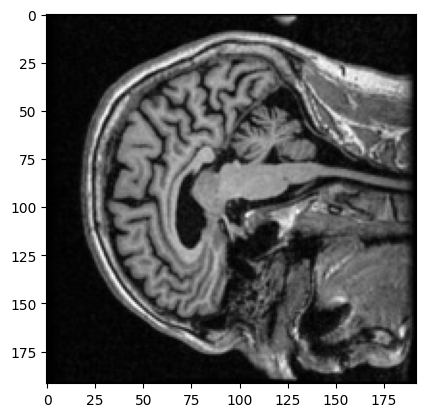

In [34]:
import matplotlib.pyplot as plt
image, label = next(iter(val_dataloader))

idx = 3

plt.imshow(image[idx, 0, :, :], 'gray')
print('label : ', label[idx])
plt.show()

### Model Setting

torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

In [35]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, config.num_filter[0], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) ## 96x96
            )

        self.layer2 = nn.Sequential(
            nn.Conv2d(config.num_filter[0], config.num_filter[1], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) ## 48x48
            )

        self.layer3 = nn.Sequential(
            nn.Conv2d(config.num_filter[1], config.num_filter[2], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) ## 24x24
            )

        self.fc1 = nn.Linear(24 * 24 * 32, 1000)
        self.fc2 = nn.Linear(1000, 3)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1) ## Vectorize, Flatten
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [36]:
model = ConvNet().to(device)
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=18432, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=3, bias=True)
)


In [ ]:
from torchvision import models

model_resnet = models.resnet18(pretrained=False)

# change input layer
# the default number of input channel in the resnet is 3, but our images are 1 channel. So we have to change 3 to 1.
# nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) <- default
# model_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# change fc layer
# the number of classes in our dataset is 3. default is 1000.
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 3)

In [ ]:
model = model_resnet.to(device)
print(model)

### Optimizer

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

### Loss Function

In [38]:
loss_f = nn.CrossEntropyLoss(reduction='sum')
loss_f_batch = nn.CrossEntropyLoss(reduction='none')

In [39]:
##  log: ['gradients', 'parameters', 'all']
## log_freq	: N 배치마다 그레이디언트와 파라미터를 로그

wandb.watch(model, loss_f, log="all", log_freq=10)

### Model Training

In [40]:
tr_losses = []
val_losses = []
for epoch in range(1, config.epochs):
    model.train() ### Train mode로 변경
    batch_loss = 0
    tqdm_loader = tqdm(tr_dataloader) ## progressing bar
    for batch_idx, samples in enumerate(tqdm_loader): ### 다음 batch 가져옴
        images, labels = samples
        images = images.to(device) ### GPU에 올림
        labels = labels.to(device)

        logit = model(images) ### forward() 실행 -> feed forward!!

        tr_loss = loss_f(logit, labels.squeeze(-1)) ### loss 계산
        optimizer.zero_grad() ### 이전에 계산했던 gradient들 초기화 (누적되면 안됨)
        tr_loss.backward() ### gradient계산 및 back propagation
        optimizer.step() #### update

        tr_loss_batch = loss_f_batch(logit, labels.squeeze(-1)) ### batch 구성하는 각 데이터 loss 계산
        batch_loss += tr_loss_batch.sum().item()

    epoch_loss = batch_loss / len(tr_dataloader)*config.batch_size
    tr_losses.append(epoch_loss)


    model.eval()
    with torch.no_grad():
        val_batch_loss = 0
        for batch_idx, samples in enumerate(val_dataloader):
            val_images, val_labels = samples
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_labels_pred = model(val_images)

            val_loss_batch = loss_f_batch(val_labels_pred, val_labels.squeeze(-1))
            val_batch_loss += val_loss_batch.sum().item()

        val_epoch_loss = val_batch_loss / len(val_dataloader)*config.batch_size
        val_losses.append(val_epoch_loss)


    print(f"Epoch {epoch:04} | train_Loss: {epoch_loss:.6f} | val_Loss: {val_epoch_loss:.6f}")
    wandb.log({"train_loss": epoch_loss, "val_loss" : val_epoch_loss})

100%|██████████| 630/630 [00:54<00:00, 11.50it/s]


Epoch 0001 | train_Loss: 66.457274 | val_Loss: 4565.321777


100%|██████████| 630/630 [00:54<00:00, 11.60it/s]


Epoch 0002 | train_Loss: 66.607445 | val_Loss: 4383.711914


100%|██████████| 630/630 [00:52<00:00, 11.98it/s]


Epoch 0003 | train_Loss: 55.162918 | val_Loss: 7003.859863


100%|██████████| 630/630 [00:51<00:00, 12.16it/s]


Epoch 0004 | train_Loss: 26.428685 | val_Loss: 13670.458984


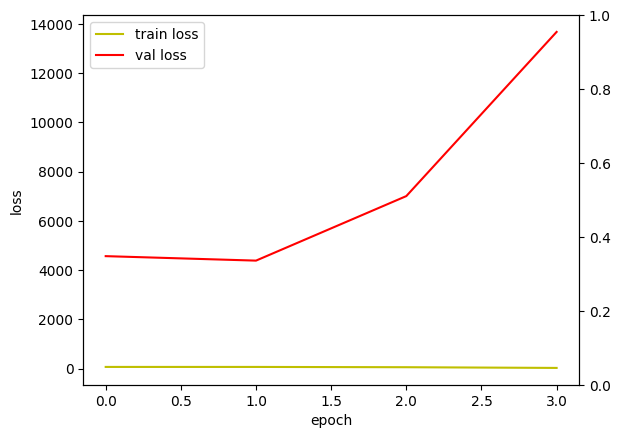

In [41]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(tr_losses, 'y', label = 'train loss')
loss_ax.plot(val_losses, 'r', label = 'val loss')

# acc_ax.plot(hist.history['accuracy'], 'b', label = 'train accuracy')
# acc_ax.plot(hist.history['val_accuracy'], 'g', label = 'valid accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

plt.show()

# 4. Model Test

In [42]:
from sklearn.metrics import accuracy_score

In [43]:
model.eval()
correct_count = 0
with torch.no_grad():
    for batch_idx, samples in enumerate(test_dataloader):
        x_test, y_test = samples
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        y_test_pred = model(x_test)

        pred = torch.argmax(y_test_pred, dim=1)
        correct_count += accuracy_score(y_test.cpu(), pred.cpu(), normalize=False) ## normalize : If False, return the number of correctly classified samples. Otherwise, return the fraction of correctly classified samples.

print('accuracy on test set : ', correct_count / len(test_dataset))


accuracy on test set :  0.3761904761904762


0.3252215508622407


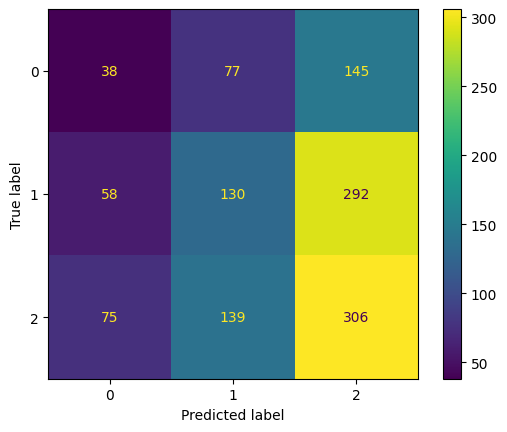

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
cm = confusion_matrix(y_test.cpu(), torch.argmax(y_test_pred,1).cpu(), labels=[0,1,2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
disp.plot()

print(f1_score(y_test.cpu(), torch.argmax(y_test_pred,1).cpu(), average='macro'))